In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
import re
import time
import pickle
import random
import torch
import numpy as np
import pandas as pd
import matplotlib.colors as pc
import matplotlib.pyplot as plt
from huggingface_hub import login
from getpass import getpass
from tqdm.autonotebook import tqdm
from resources.auc_score import AUCScorer
from resources.testing import PerturbationTester
from resources.modelling import ChatGenerationPipeline

In [2]:
MAX_SEQ_LEN = 512
MAX_GEN_LEN = 128
MODEL_NAME  = "meta-llama/Meta-Llama-3.1-8B-Instruct"

# Prepare:

## Log in to Huggingface:

In [3]:
torch.manual_seed(42)
if os.path.exists('.huggingface.token'):
    with open('.huggingface.token', 'r') as file:
        login(token=file.read())

else: login(token=getpass(prompt='Huggingface login  token: '))

## Load model:

In [4]:
pipe = ChatGenerationPipeline.from_pretrained(
    MODEL_NAME,
    max_seq_len = MAX_SEQ_LEN,
    max_gen_len = MAX_GEN_LEN,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    attn_implementation="eager",
)

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

# Qualitative experiments:

In [5]:
def get_probabilities(labels, tokens):
    result = {}
    for precise in [False, True]:
        key = 'precise' if precise else 'approximated'
        result[key] = {}
        for l, ts in zip(labels, tokens):
            t = time.time_ns()
            p = pipe.getOutputProbability(ts, precise=precise)
            t = time.time_ns() - t
        
            result[key][l] = {'p': float(p.detach().to(device='cpu', dtype=float).numpy()), 'dt': t}
    
    return result

In [6]:
def get_saliencies(methods, labels, true_label, tester):
    result = {}
    for precise, aggregation in [(False, ''), (True, 'saliency'), (True, 'cumsum'), (True, 'equal')]:
        key = aggregation if precise else 'approximated'
        result[key] = {}
        for f in methods:
            t = time.time_ns()
            s = f(precise=precise, normalize=True, aggregation=aggregation)
            t = time.time_ns() - t
    
            # per token in label:
            s = {labels[i]: s[i,:] for i in range(s.shape[0])}
    
            # compute perturbation:
            c = tester.test(s[true_label].abs())
    
            result[key][f.__name__]= {'s': {key: s[key].detach().to(device='cpu', dtype=float).numpy() for key in s}, 'c':c, 'dt': t}

    return result

In [7]:
def plot_saliency(ax, saliency, start, stop, labels, input_tokens):
    s = {l:np.abs(saliency['s'][l][start:stop]) for l in labels}
    for l in labels: print(l, [input_tokens[i] for i in np.argsort(s[l])[-1:-11:-1] + start])
    ax.imshow([s[l] for l in labels])
    ax.set_yticks(ticks=np.arange(len(labels)), labels=labels)
    ax.set_xticks(ticks=np.arange(stop-start), labels=input_tokens[start:stop], rotation=90)

In [8]:
def plot_moves(ax, probabilities, piece, norm):
    board = np.zeros((8,8), dtype=float)

    for move, p in zip(probabilities.index, probabilities.p.values):
        if move.startswith(piece):
            col = ord(move[-2]) - ord('a')
            row = int(move[-1]) - 1

            board[row, col] = p

    hm = ax.imshow(board[::-1], norm=norm)
    ax.hlines(np.arange(7)+.5, -.5, 7.5, colors='gray')
    ax.vlines(np.arange(7)+.5, -.5, 7.5, colors='gray')

    if piece == 'pawn':
        for x in range(8):
            ax.arrow(x-.1, 5.6, 0, -.4, head_width=.2, head_length=.2, color='red')
            ax.arrow(x+.1, 5.6, 0, -1.4, head_width=.2, head_length=.2, color='red')
            ax.text(x, 6, '♟', horizontalalignment='center', verticalalignment='center', color='white', family='DejaVu Sans', size='xx-large')

    if piece == 'knight': 
        for x in [1, 6]:
            ax.arrow(x, 6.6, 0, -1.4, head_width=.2, head_length=.2, color='red')
            ax.arrow(x+.1, 5, +.7, 0, head_width=.2, head_length=.2, color='red')
            ax.arrow(x-.1, 5, -.7, 0, head_width=.2, head_length=.2, color='red')
            ax.text(x, 7, '♞', horizontalalignment='center', verticalalignment='center', color='white', family='DejaVu Sans', size='xx-large')

    ax.set_yticks(ticks=np.arange(8)[::-1], labels=["1", "2", "3", "4", "5", "6", "7", "8"])
    ax.set_xticks(ticks=np.arange(8), labels=["a", "b", "c", "d", "e", "f", "g", "h"])

    return hm

## Example 1:

In [9]:
# create prompt:
prompt = "Who was the first president of the United States?\n"

# add candidates:
labels = ["George R. R. Martin", "George Washington", "Abraham Lincoln"]
tokens = [pipe.tokenizer.convert_ids_to_tokens(pipe.tokenizer(l)['input_ids'][1:]) for l in labels]
max_new_tokens = max([len(l) for l in tokens]) + 2

for l in labels[:-1]: prompt+= f"{l}, "
prompt+= f"or {labels[-1]}?\n"

# add suffix:
suffix = "Make sure to answer with one of the previous options! Only answer with the name!"
prompt += suffix

print(prompt)

Who was the first president of the United States?
George R. R. Martin, George Washington, or Abraham Lincoln?
Make sure to answer with one of the previous options! Only answer with the name!


In [10]:
# prompt LLM:
chat, input_ids, output_ids = pipe.generate(prompt, output_attentions=True, output_hidden_states=True, compute_grads=tokens, max_new_tokens=max_new_tokens)

input_tokens = pipe.tokenizer.convert_ids_to_tokens(input_ids[0])
start = pipe.countTokens('', sot=True)
stop  = len(input_tokens) - pipe.countTokens(suffix, eot=True)

tester = PerturbationTester(
    input_ids, start, stop, pipe.mask_token_id,
    pipe.model, pipe.tokenizer
)
prediction = chat[1][1].split('\n')[0].strip('"*. ')

chat

/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


['<|begin_of_text|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ']
['Make', 'Ġsure', 'Ġto', 'Ġanswer', 'Ġwith', 'Ġone', 'Ġof', 'Ġthe', 'Ġprevious', 'Ġoptions', '!', 'ĠOnly', 'Ġanswer', 'Ġwith', 'Ġthe', 'Ġname', '!', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ']


[('user',
  'Who was the first president of the United States?\nGeorge R. R. Martin, George Washington, or Abraham Lincoln?\nMake sure to answer with one of the previous options! Only answer with the name!'),
 ('assistant', 'George Washington')]

### Probabilities: 

In [11]:
p = get_probabilities(labels, tokens)

In [12]:
# approximated:
p_approximated = pd.DataFrame(p['approximated']).T
p_approximated.sort_values(by='p', inplace=True, ascending=False)
p_approximated

,p,dt
George R. R. Martin,1.000000,261698.0
George Washington,1.000000,82699.0
Abraham Lincoln,0.000005,71760.0


In [13]:
# precise:
p_precise = pd.DataFrame(p['precise']).T
p_precise.sort_values(by='p', inplace=True, ascending=False)
p_precise

,p,dt
George Washington,1.000000,46306444.0
George R. R. Martin,0.000023,285275492.0
Abraham Lincoln,0.000005,92096871.0


### Saliencies:

In [14]:
s = get_saliencies([pipe.gradH, pipe.gradIn], labels, "George Washington", tester)

George Washington ['ĠR', 'ĠMartin', 'ĠAbraham', 'ĠWashington', 'ĠLincoln', 'Ġwas', 'Ġfirst', 'Ġpresident', ',', '.']
George R. R. Martin ['ĠR', 'ĠMartin', 'ĠAbraham', 'ĠWashington', 'ĠLincoln', 'Ġwas', 'Ġfirst', 'Ġpresident', ',', '.']
Abraham Lincoln ['ĠR', 'ĠMartin', 'ĠAbraham', 'ĠWashington', 'ĠLincoln', 'Ġwas', 'Ġfirst', 'Ġpresident', ',', '.']
George Washington ['George', 'ĠWashington', ',', 'ĠR', 'ĠLincoln', 'ĠGeorge', 'ĠAbraham', '?Ċ', 'Ġfirst', 'Ġthe']
George R. R. Martin ['ĠGeorge', 'ĠR', 'George', 'Ġor', ',', 'Ġwas', '?Ċ', 'ĠAbraham', 'ĠWashington', '.']
Abraham Lincoln ['ĠWashington', ',', 'ĠAbraham', ',', 'Ġfirst', 'Ġor', 'ĠLincoln', 'Ġwas', '?Ċ', '?Ċ']
George Washington ['ĠMartin', 'ĠWashington', 'ĠLincoln', ',', 'ĠGeorge', 'George', '?Ċ', 'ĠAbraham', 'Ġthe', 'Ġfirst']
George R. R. Martin ['ĠGeorge', 'George', 'ĠR', 'Ġor', ',', 'ĠAbraham', '?Ċ', 'Ġwas', 'ĠMartin', 'ĠWashington']
Abraham Lincoln ['ĠWashington', 'ĠAbraham', ',', 'ĠMartin', 'ĠR', 'ĠLincoln', ',', 'Ġfirst', 'Ġ

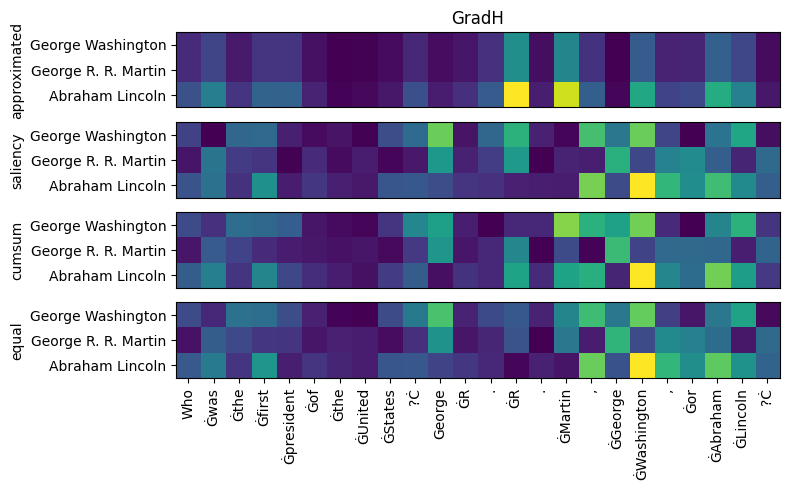

In [15]:
fig, axs = plt.subplots(len(s), 1, figsize=(8, 1+len(s)))

for i, key in enumerate(s):
    hm = plot_saliency(axs[i], s[key]['gradH'], start, stop, p_precise.index[:5], input_tokens)
    axs[i].set_ylabel(key)
    if i < (len(s)-1): axs[i].set_xticks([])

axs[0].set_title('GradH')
fig.tight_layout()

path = f'plots/{MODEL_NAME.lower()}'
os.makedirs(path, exist_ok=True)
fig.savefig(f'{path}/president-gradH.pdf')
fig.show()

George Washington ['ĠWashington', 'ĠR', 'ĠR', '?Ċ', ',', 'ĠAbraham', 'Ġor', 'Ġwas', '.', 'Ġthe']
George R. R. Martin ['ĠWashington', 'ĠR', 'ĠR', '?Ċ', ',', 'ĠAbraham', 'Ġor', 'Ġwas', '.', 'Ġthe']
Abraham Lincoln ['ĠWashington', 'ĠR', 'ĠR', '?Ċ', ',', 'ĠAbraham', 'Ġor', 'Ġwas', '.', 'Ġthe']
George Washington [',', '?Ċ', '?Ċ', 'ĠWashington', 'Ġthe', '.', 'Ġor', 'ĠR', 'ĠAbraham', 'ĠUnited']
George R. R. Martin ['ĠWashington', '?Ċ', 'Ġthe', 'ĠR', 'Ġthe', '.', 'ĠR', ',', '?Ċ', 'Ġwas']
Abraham Lincoln [',', '?Ċ', '.', 'ĠWashington', 'Ġthe', 'ĠR', 'Ġor', 'ĠAbraham', 'Ġwas', '?Ċ']
George Washington [',', '?Ċ', 'Ġthe', '?Ċ', 'ĠWashington', '.', 'ĠAbraham', 'ĠUnited', 'Ġor', 'ĠR']
George R. R. Martin ['ĠWashington', '?Ċ', 'Ġthe', 'ĠR', '.', 'Ġthe', '?Ċ', 'Ġor', 'Ġwas', ',']
Abraham Lincoln [',', 'ĠWashington', '.', 'ĠR', 'Ġor', 'ĠAbraham', 'Ġthe', '?Ċ', 'Ġwas', '?Ċ']
George Washington [',', '?Ċ', '?Ċ', 'Ġthe', 'ĠWashington', '.', 'ĠAbraham', 'Ġor', 'ĠUnited', 'ĠR']
George R. R. Martin ['ĠWashing

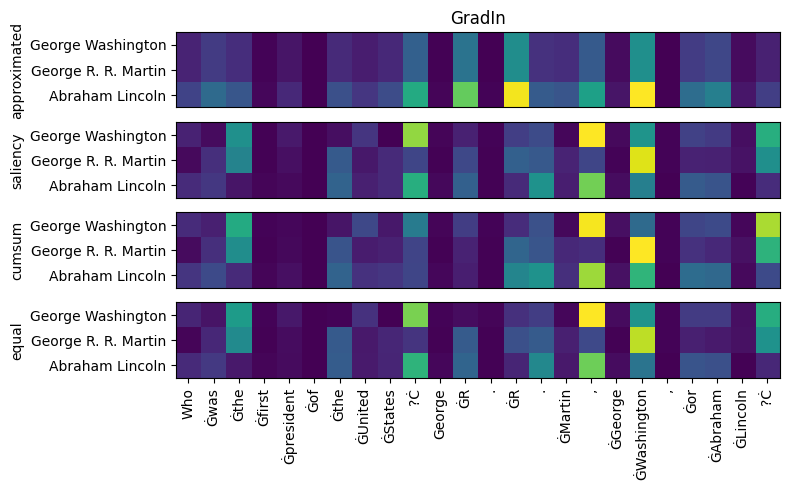

In [16]:
fig, axs = plt.subplots(len(s), 1, figsize=(8, 1+len(s)))

for i, key in enumerate(s):
    hm = plot_saliency(axs[i], s[key]['gradIn'], start, stop, p_precise.index[:5], input_tokens)
    axs[i].set_ylabel(key)
    if i < (len(s)-1): axs[i].set_xticks([])

axs[0].set_title('GradIn')
fig.tight_layout()

path = f'plots/{MODEL_NAME.lower()}'
os.makedirs(path, exist_ok=True)
fig.savefig(f'{path}/president-gradIn.pdf')
fig.show()

In [17]:
scorer = AUCScorer({
    aggregation: [{
        'prediction': {'text': prediction.lower()},
        'perturbation': {method:s[aggregation][method]['c'] for method in s[aggregation]}
    }] for aggregation in s
})

scorer.score_table(average=True)

,approximated,saliency,cumsum,equal
gradH,0.312322,0.582949,0.291834,0.395844
gradIn,-0.020488,0.186926,-0.104254,0.103715


## Example 2:

In [18]:
# create prompt:
prompt = "Let's play chess! It's a new game. You play white. It's your turn. Announce your move in the following pattern: [piece] to [tile]. "

# add candidates:
pieces  = ["queen", "king", "bishop", "knight", "rook", "pawn"]
rows    = ["1", "2", "3", "4", "5", "6", "7", "8"]
columns = ["a", "b", "c", "d", "e", "f", "g", "h"]

labels  = [f"{piece} to {col}{row}"
    for piece in pieces
    for row in rows
    for col in columns
]

tokens = [pipe.tokenizer.convert_ids_to_tokens(pipe.tokenizer(l)['input_ids'][1:]) for l in labels]
max_new_tokens = max([len(l) for l in tokens]) + 2

# add suffix:
suffix = "Make sure to only answer with your move in the previously described pattern!"
prompt += suffix

print(prompt)

Let's play chess! It's a new game. You play white. It's your turn. Announce your move in the following pattern: [piece] to [tile]. Make sure to only answer with your move in the previously described pattern!


In [19]:
# prompt LLM:
chat, input_ids, output_ids = pipe.generate(prompt, output_attentions=True, output_hidden_states=True, compute_grads=tokens, max_new_tokens=max_new_tokens)

input_tokens = pipe.tokenizer.convert_ids_to_tokens(input_ids[0])
start = pipe.countTokens('', sot=True)
stop  = len(input_tokens) - pipe.countTokens(suffix, eot=True)

tester = PerturbationTester(
    input_ids, start, stop, pipe.mask_token_id,
    pipe.model, pipe.tokenizer
)
prediction = chat[1][1].split('\n')[0].strip('"*. ')

chat

/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(
/home/h21/kora8563/venv/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(


['<|begin_of_text|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ']
['Make', 'Ġsure', 'Ġto', 'Ġonly', 'Ġanswer', 'Ġwith', 'Ġyour', 'Ġmove', 'Ġin', 'Ġthe', 'Ġpreviously', 'Ġdescribed', 'Ġpattern', '!', '<|eot_id|>', '<|start_header_id|>', 'user', '<|end_header_id|>', 'ĊĊ']


[('user',
  "Let's play chess! It's a new game. You play white. It's your turn. Announce your move in the following pattern: [piece] to [tile]. Make sure to only answer with your move in the previously described pattern!"),
 ('assistant', 'Pawn to e4.')]

### Probabilities: 

In [20]:
p = get_probabilities(labels, tokens)

In [21]:
# approximated:
p_approximated = pd.DataFrame(p['approximated']).T
p_approximated.sort_values(by='p', inplace=True, ascending=False)
p_approximated

,p,dt
pawn to h8,0.003204,65119.0
pawn to h4,0.003204,64069.0
pawn to f4,0.003204,64640.0
pawn to e4,0.003204,64070.0
pawn to d4,0.003204,64500.0
...,...,...
queen to g5,0.000017,66810.0
queen to f5,0.000017,64999.0
queen to e5,0.000017,65580.0
queen to d5,0.000017,65240.0


In [22]:
# precise:
p_precise = pd.DataFrame(p['precise']).T
p_precise.sort_values(by='p', inplace=True, ascending=False)
p_precise

,p,dt
pawn to e4,3.173828e-03,138132384.0
knight to b3,4.043579e-04,184289013.0
knight to g3,1.316071e-04,184094134.0
bishop to c4,8.153915e-05,137411368.0
knight to c3,7.534027e-05,184858649.0
...,...,...
pawn to g8,2.813749e-12,138196535.0
pawn to c1,1.065814e-12,138002506.0
pawn to h8,9.308110e-13,137936815.0
pawn to d8,8.775203e-13,138034715.0


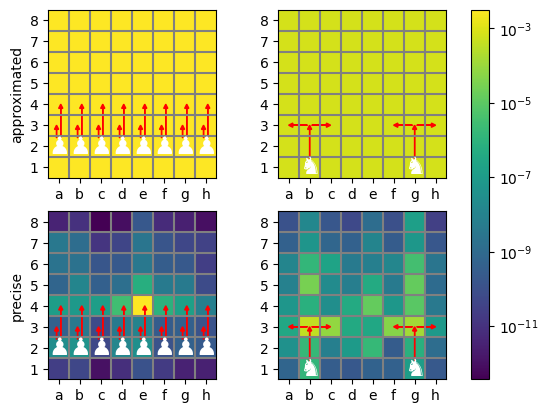

In [23]:
fig, axs = plt.subplots(2, 2)

norm = pc.LogNorm(
    vmin=min(p_precise['p'].values.min(), p_approximated['p'].values.min()),
    vmax=max(p_precise['p'].values.max(), p_approximated['p'].values.max())
)

hm = plot_moves(axs[0,0], p_approximated, 'pawn', norm)
hm = plot_moves(axs[0,1], p_approximated, 'knight', norm)
axs[0,0].set_ylabel('approximated')

hm = plot_moves(axs[1,0], p_precise, 'pawn', norm)
hm = plot_moves(axs[1,1], p_precise, 'knight', norm)
axs[1,0].set_ylabel('precise')

plt.colorbar(hm, ax=axs, fraction=.1)

path = f'plots/{MODEL_NAME.lower()}'
os.makedirs(path, exist_ok=True)
fig.savefig(f'{path}/chess-p.pdf')
fig.show()

### Saliencies:

In [24]:
s = get_saliencies([pipe.gradH, pipe.gradIn], labels, "pawn to e4", tester)

pawn to h8 [':', 'Ġplay', 'Ġthe', 'Ġpattern', 'Ġchess', 'Ġin', 'ounce', "'s", '!', ']']
pawn to h4 [':', 'Ġplay', 'Ġthe', 'Ġpattern', 'Ġchess', 'Ġin', 'ounce', "'s", '!', ']']
pawn to f4 [':', 'Ġplay', 'Ġthe', 'Ġpattern', 'Ġchess', 'Ġin', 'ounce', "'s", '!', ']']
pawn to e4 [':', 'Ġplay', 'Ġthe', 'Ġpattern', 'Ġchess', 'Ġin', 'ounce', "'s", '!', ']']
pawn to d4 [':', 'Ġplay', 'Ġthe', 'Ġpattern', 'Ġchess', 'Ġin', 'ounce', "'s", '!', ']']
pawn to h8 ['Ġplay', 'Ġpattern', 'Ġthe', 'Ġto', ':', '].', ']', 'tile', 'piece', 'Ġyour']
pawn to h4 ['Ġto', ':', 'Ġplay', 'Ġpattern', '].', ']', 'Ġthe', 'piece', 'Ġchess', 'tile']
pawn to f4 ['Ġplay', 'Ġ[', ':', 'Ġchess', 'Ġthe', 'Ġto', ']', 'ounce', 'Ġpattern', "'s"]
pawn to e4 [']', 'Ġthe', '].', 'Ġpattern', 'Ġfollowing', 'Ġin', 'Ġto', 'Ġplay', 'ounce', '.']
pawn to d4 ['Ġthe', 'Ġto', ':', '].', 'Ġplay', 'Ġpattern', ']', 'Ġchess', 'piece', 'ounce']
pawn to h8 [':', 'Ġplay', 'Ġthe', 'Ġpattern', '].', ']', 'Ġin', 'tile', 'Ġchess', 'Ġto']
pawn to h4 [':'

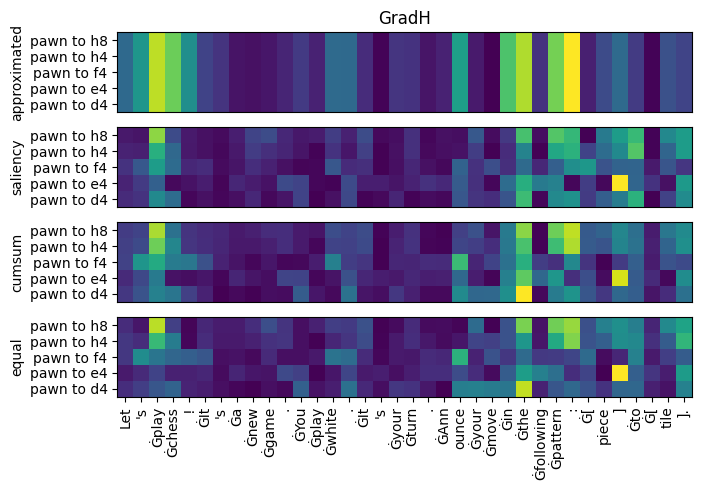

In [25]:
fig, axs = plt.subplots(len(s), 1, figsize=(8, 1+len(s)))

for i, key in enumerate(s):
    hm = plot_saliency(axs[i], s[key]['gradH'], start, stop, p_approximated.index[:5], input_tokens)
    axs[i].set_ylabel(key)
    if i < (len(s)-1): axs[i].set_xticks([])

axs[0].set_title('GradH')
fig.tight_layout()

path = f'plots/{MODEL_NAME.lower()}'
os.makedirs(path, exist_ok=True)
fig.savefig(f'{path}/chess-gradH.pdf')

pawn to h8 ['Ġfollowing', 'Ġin', ':', 'Ġplay', 'Ġgame', 'Ġchess', 'ĠYou', 'piece', 'Ġpattern', "'s"]
pawn to h4 ['Ġfollowing', 'Ġin', ':', 'Ġplay', 'Ġgame', 'Ġchess', 'ĠYou', 'piece', 'Ġpattern', "'s"]
pawn to f4 ['Ġfollowing', 'Ġin', ':', 'Ġplay', 'Ġgame', 'Ġchess', 'ĠYou', 'piece', 'Ġpattern', "'s"]
pawn to e4 ['Ġfollowing', 'Ġin', ':', 'Ġplay', 'Ġgame', 'Ġchess', 'ĠYou', 'piece', 'Ġpattern', "'s"]
pawn to d4 ['Ġfollowing', 'Ġin', ':', 'Ġplay', 'Ġgame', 'Ġchess', 'ĠYou', 'piece', 'Ġpattern', "'s"]
pawn to h8 ['Ġ[', 'piece', 'Ġplay', '!', ']', ':', 'Ġfollowing', 'Ġ[', 'Ġyour', 'Ġin']
pawn to h4 ['Ġ[', 'piece', 'Ġfollowing', 'Ġin', 'Ġgame', 'ounce', 'Ġplay', ']', '!', 'ĠIt']
pawn to f4 ['Ġ[', 'Ġgame', 'Ġfollowing', 'piece', 'ounce', 'Ġin', ']', 'Ġplay', 'ĠIt', 'Ġturn']
pawn to e4 ['Ġ[', ']', 'piece', ':', 'ounce', 'Ġpattern', 'Ġ[', 'ĠAnn', '].', 'ĠIt']
pawn to d4 ['Ġ[', 'piece', 'ounce', 'Ġin', 'Ġfollowing', 'Ġgame', ']', 'Ġplay', 'ĠIt', '!']
pawn to h8 ['piece', 'Ġ[', ':', 'Ġpattern',

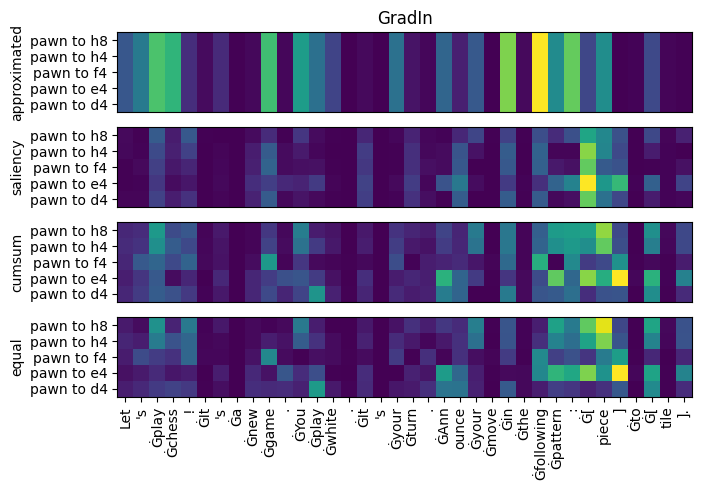

In [26]:
fig, axs = plt.subplots(len(s), 1, figsize=(8, 1+len(s)))

for i, key in enumerate(s):
    hm = plot_saliency(axs[i], s[key]['gradIn'], start, stop, p_approximated.index[:5], input_tokens)
    axs[i].set_ylabel(key)
    if i < (len(s)-1): axs[i].set_xticks([])

axs[0].set_title('GradIn')
fig.tight_layout()

path = f'plots/{MODEL_NAME.lower()}'
os.makedirs(path, exist_ok=True)
fig.savefig(f'{path}/chess-gradIn.pdf')
fig.show()

In [27]:
scorer = AUCScorer({
    aggregation: [{
        'prediction': {'text': prediction.lower()},
        'perturbation': {method:s[aggregation][method]['c'] for method in s[aggregation]}
    }] for aggregation in s
})

scorer.score_table(average=True)

,approximated,saliency,cumsum,equal
gradH,0.208166,0.111068,0.208182,0.000000
gradIn,0.208182,0.097115,-0.111068,-0.111068
